# Homework 2 solutions

## 1

We want to extend Simpson's rule to work with an odd number of intervals.  In class we found that the equation of a parabola that passes through $(x_0, f_0)$, $(x_1, f_1)$, $(x_2, f_2)$ is:

$$f(x) = \frac{f_0 - 2 f_1 + f_2}{2 \Delta x^2} (x - x_0)^2 
      + \frac{-3 f_0 + 4 f_1 - f_2}{2 \Delta x} (x - x_0) + f_0$$
      
Let's imagine that we are at the end of the domain, and we just have the single interval $[x_{N-1}, x_N]$ to integrate over.

We can do this by defining the parabola to pass through $\{x_{N-2}, x_{N-1}, x_N\}$ and then just integrate over the right half.

We'll follow the SymPy derivation from class (but it is also easy to do this integral by hand).

In [1]:
from sympy import init_session
init_session()

IPython console for SymPy 1.11.1 (Python 3.11.1-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.11.1/



In [2]:
a, b, c = symbols("a b c")
dx = symbols("\Delta{}x")
fN2, fN1, fN = symbols("f_{N-2} f_{N-1} f_N")

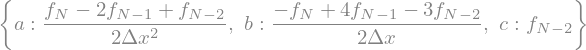

In [3]:
coeffs = solve([Eq(fN2, c),
                Eq(fN1, a * dx**2 + b * dx + c),
                Eq(fN, 4 * a * dx**2 + 2 * b * dx + c)],
               [a, b, c])
coeffs

In [4]:
xN2 = symbols("x_{N-2}")

Here, we change the limits that we integrate over to just be $[x_{N-1}, x_N]$

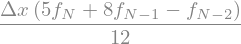

In [5]:
I = integrate(coeffs[a] * (x - xN2)**2 + coeffs[b] * (x - xN2) + coeffs[c],
              [x, xN2+dx, xN2+2*dx])
simplify(I)

So that would be the contribution to the integral from a single remaining interval if the number of intervals is odd

Let's write a function that integrates a function, `f`, from [`a`,`b`] with `N` intervals, where `N` may be odd.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def I_s(f, a, b, N):
    """composite Simpsons rule.  Integrate f over [a, b]
    with N intervals"""
    
    # get the spacing of the intervals
    
    dx = (b - a) / N
    
    I = 0.0

    # loop over bins
    for n in range(0, N-1, 2):
        x0 = a + n * dx
        x1 = a + (n+1) * dx
        x2 = a + (n+2) * dx
        I += dx / 3.0 * (f(x0)+ 4 * f(x1) + f(x2))

    # if N is odd, we have one interval remaining
    if N % 2 == 1:
        x_N2 = b - 2 * dx
        x_N1 = b - dx
        x_N = b
        I += dx / 12.0 * (5 * f(x_N) + 8 * f(x_N1) - f(x_N2))
    return I

In [5]:
def f(x):
    return x * np.sin(2 * np.pi * x)

def I_analytic():
    return - 5.0 / (2.0 * np.pi)

It's always useful to plot the integrand.

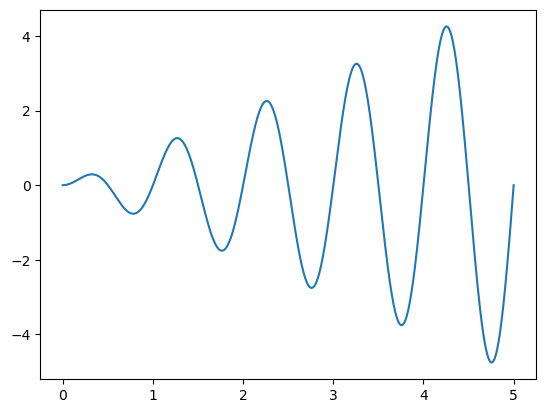

In [7]:
fig, ax = plt.subplots()
x = np.linspace(0, 5, 1000)
ax.plot(x, f(x))

As we can see, there will be alternating postive and negative contributions, and we'll need a lot of resolution to get this right.

In [8]:
for n in [3, 5, 9, 17, 33, 65, 129, 257]:
    print(f"{n:4} : {abs(I_s(f, 0, 5, n) - I_analytic())}")

   3 : 2.5999943066770577
   5 : 0.7957747154594665
   9 : 1.1876938529724823
  17 : 0.06439588165114829
  33 : 0.01730255273921677
  65 : 0.0017456127932892196
 129 : 0.00012529082068590824
 257 : 8.22252017085301e-06


## 2

We have:
    
$$n(p) d^3 p \rightarrow 4\pi n(p) p^2 dp = \frac{n_I}{(2\pi m_I k_B T)^{3/2}} e^{-p^2/(2m_I k_BT)} 4\pi p^2 dp$$

and want to compute:

$$\langle v \rangle = \frac{1}{n_I} \int_0^\infty 4\pi n(p) p^2 \left (\frac{p}{m_I}\right ) dp$$

Let's start by making this integral dimensionless

Defining 

$$x = \frac{p}{\sqrt{2 m_I k_B T}}$$

we have

$$\langle v \rangle = 4\sqrt{\frac{2 k_B T}{m \pi}} \int_0^\infty x^3 e^{-x^2} dx$$

Let's plot the integrand

In [9]:
def f(x):
    return x**3 * np.exp(-x**2)

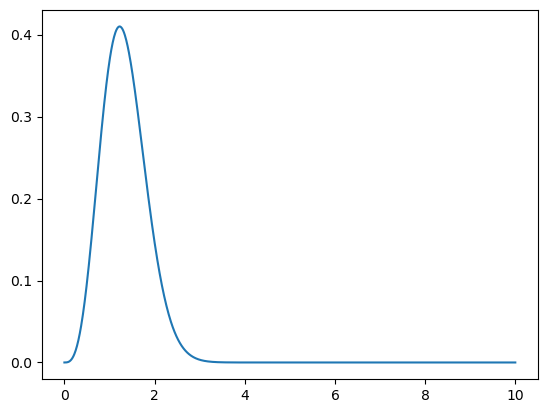

In [12]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 1000)
ax.plot(x, f(x))

This actually falls off pretty quickly, but we'll still use our method for integrating to infinity

In [13]:
SMALL = 1.e-30

def zv(x, c):
    """ transform the variable x -> z """
    return x/(c + x) 

def xv(z, c):
    """ transform back from z -> x """
    return c*z/(1.0 - z + SMALL)

We'll do the integration with the trapezoid rule

In [16]:
def I_t(func, N=10, c=5):
    """composite trapezoid rule for integrating from [0, oo].
    Here N is the number of intervals"""
    
    # there are N+1 points corresponding to N intervals
    z = np.linspace(0.0, 1.0, N+1, endpoint=True)
    
    I = 0.0
    for n in range(N):
        I += 0.5 * (z[n+1] - z[n]) * (func(xv(z[n], c)) / (1.0 - z[n] + SMALL)**2 +
                                      func(xv(z[n+1], c)) / (1.0 - z[n+1] + SMALL)**2)
    I *= c
    return I

Now let's write a function that puts back in the physical units

In [18]:
def avg_vel(T, N=10):
    kB = 1.38e-16  # erg/K
    m_I = 1.67e-24 # g
    
    return 4 * np.sqrt(2 * kB * T / (m_I * np.pi)) * I_t(f, N=N, c=2)
    

In [19]:
avg_vel(1.5e7)

56209275.06614353

That's a velocity of $5.6\times 10^7~\mathrm{cm~s^{-1}}$

The analytic expression is

In [20]:
kB = 1.38e-16  # erg/K
m_I = 1.67e-24 # g
T = 1.5e7

v = 2 * np.sqrt(2 * kB * T / (m_I * np.pi))
v

56181973.983838476

So we are very close.